In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# **Developing a Model for Photometric Redshift Estimation (Photo-z)**
## **Using Random Forest Regression**
---

### **Overview**
In this notebook, we will build and train a Random Forest model to estimate photometric redshifts (Photo-z) based on galaxy magnitudes from mock galaxy catalogs. The steps include:

1. Data preprocessing and feature selection.
2. Building the Random Forest regression model.
3. Evaluating the model's performance.
4. Visualizing the results, including $\Delta z = z_{\text{spec}} - z_{\text{photo}}$ maps and histograms.
5. Analyzing spatial selection bias and scale dependence.

---
 **Objective:** Create an efficient and robust pipeline for Photo-z estimation to support cosmological surveys like LSST.

### 1. Load the data

In [2]:
def read_data(catalog_filename, index_col=None, chunksize=10000):
    """
    Read data from a CSV file in chunks and return the first chunk.
    """
    dtype_dict = {'col1': 'int32', 'col2': 'float32'}  # Define appropriate types for each column
    for chunk in pd.read_csv(catalog_filename, sep=",", index_col=index_col, comment='#', na_values=r'\N', 
                             compression='bz2', chunksize=chunksize, dtype=dtype_dict):
        print(chunk.head())  # Process or use data here
        return chunk

In [3]:
# Read the csv.bz2 file in chunks and return the first chunk
catalog_filename = "/Users/r.kanaki/code/inlabru_nbody/data/RV_Test/rs_256_DES_mag.csv.bz2"
index_col = ["unique_gal_id"]
chunksize = 200_000_000
data_gal = read_data(catalog_filename, index_col=index_col, chunksize=chunksize)
print(data_gal.shape)

               des_asahi_full_g_abs_mag  des_asahi_full_g_true  \
unique_gal_id                                                    
373143579                       -18.217                 25.136   
486189851                       -16.013                 25.952   
483061019                       -15.498                 24.829   
480245787                       -16.382                 25.446   
18480155                        -15.856                 24.142   

               des_asahi_full_r_abs_mag  des_asahi_full_r_true  \
unique_gal_id                                                    
373143579                       -18.265                 25.152   
486189851                       -16.351                 24.907   
483061019                       -15.668                 24.273   
480245787                       -16.756                 24.337   
18480155                        -16.401                 23.198   

               des_asahi_full_i_abs_mag  des_asahi_full_i_true  \
unique_g

In [4]:
# Features and target variable
features = [
    'des_asahi_full_g_true',
    'des_asahi_full_r_true',
    'des_asahi_full_i_true',
    'des_asahi_full_z_true',
    'des_asahi_full_y_true'
]
target = 'z_cgal'  # True redshift from the catalog

X = data_gal[features]
y = data_gal[target]

### 1.1 Visualize the Data

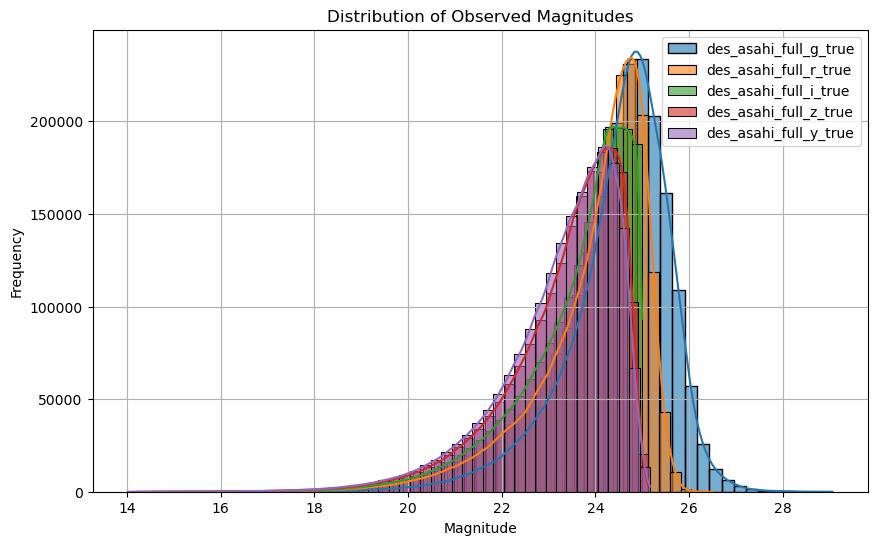

In [5]:
# Plot distributions of observed magnitudes
plt.figure(figsize=(10, 6))
for feature in features:
    sns.histplot(data_gal[feature], bins=50, kde=True, label=feature, alpha=0.6)
plt.xlabel("Magnitude")
plt.ylabel("Frequency")
plt.title("Distribution of Observed Magnitudes")
plt.legend()
plt.grid()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/observed_magnitudes.png")
plt.show()

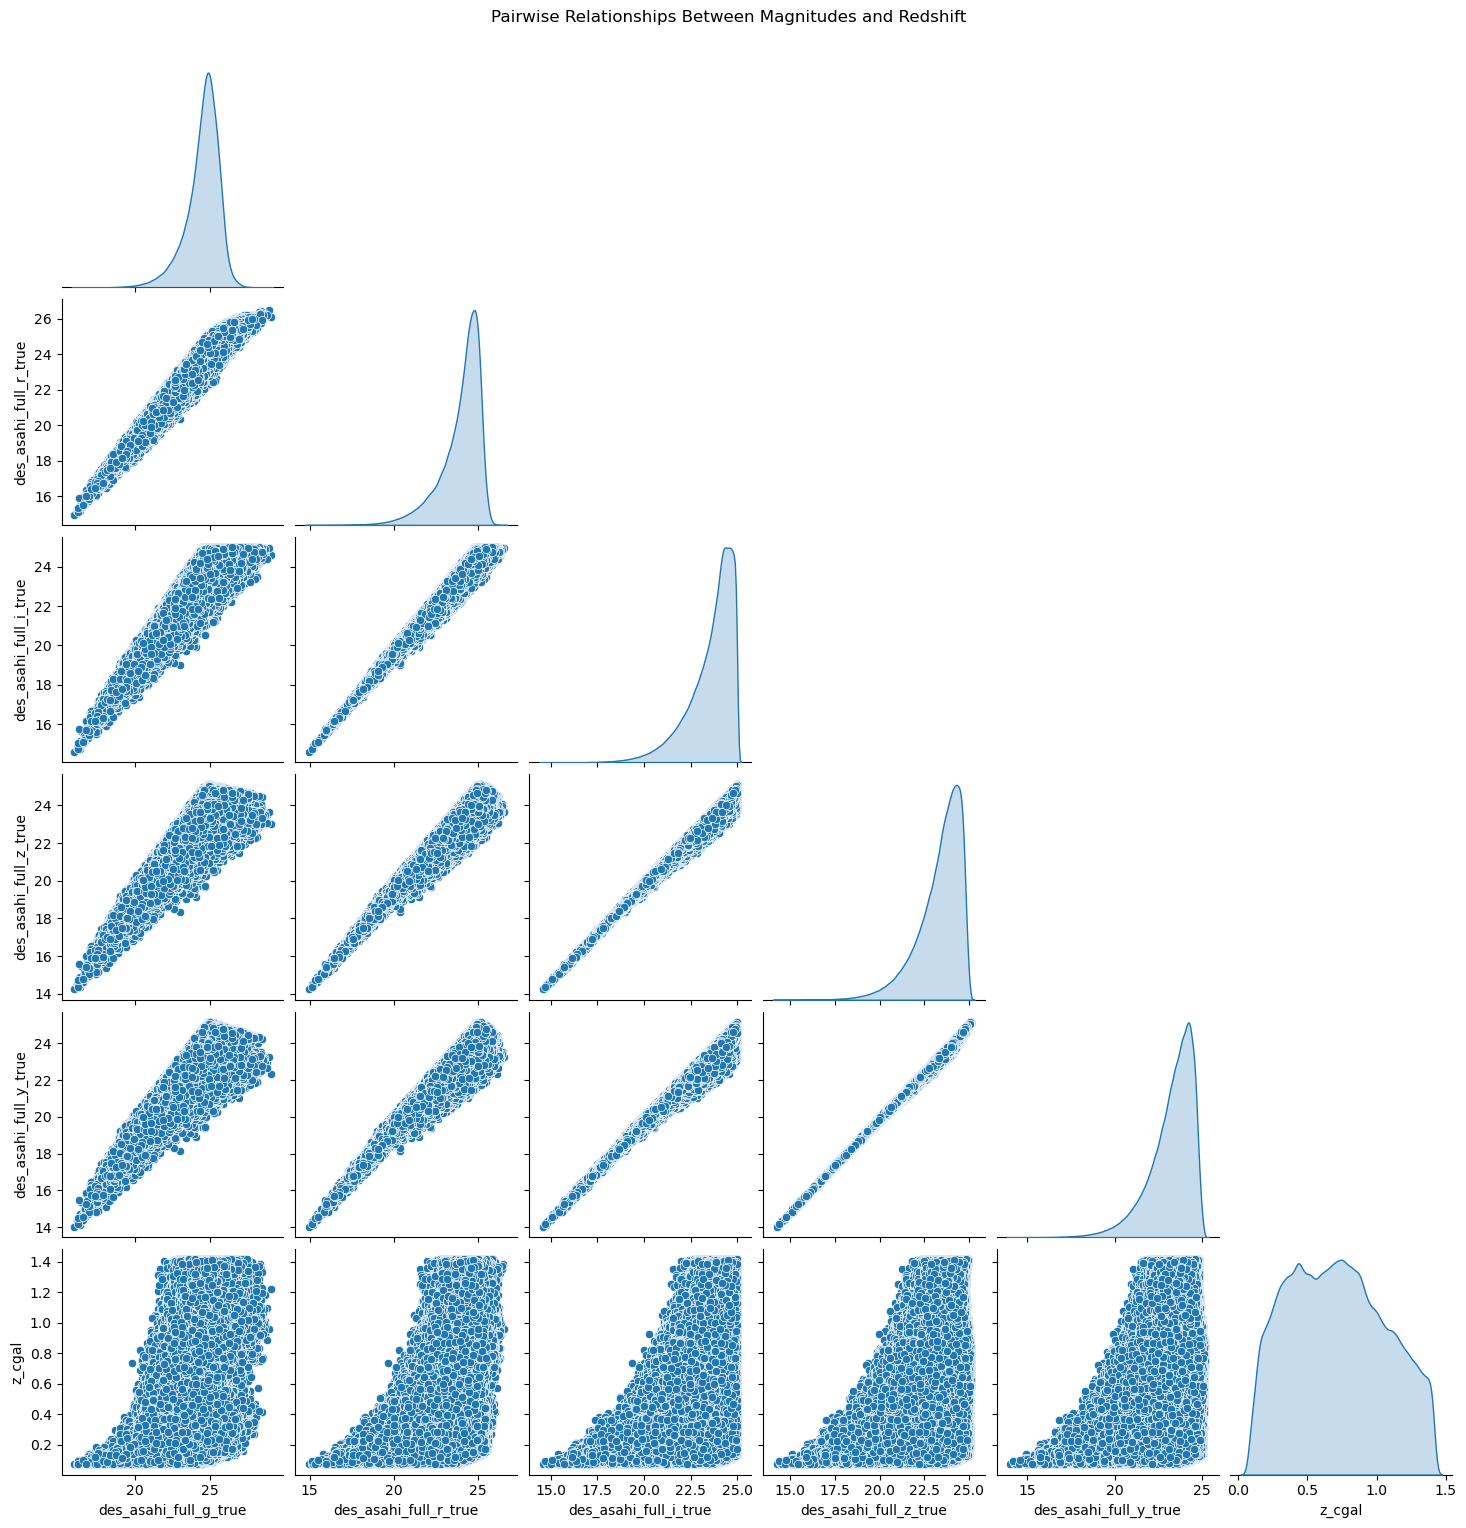

In [6]:
# Pairplot of magnitudes and redshift
sns.pairplot(data_gal, vars=features + [target], diag_kind='kde', corner=True, height=2.5)
plt.suptitle("Pairwise Relationships Between Magnitudes and Redshift", y=1.02)
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/Pairwise_Relationships.png")
plt.show()

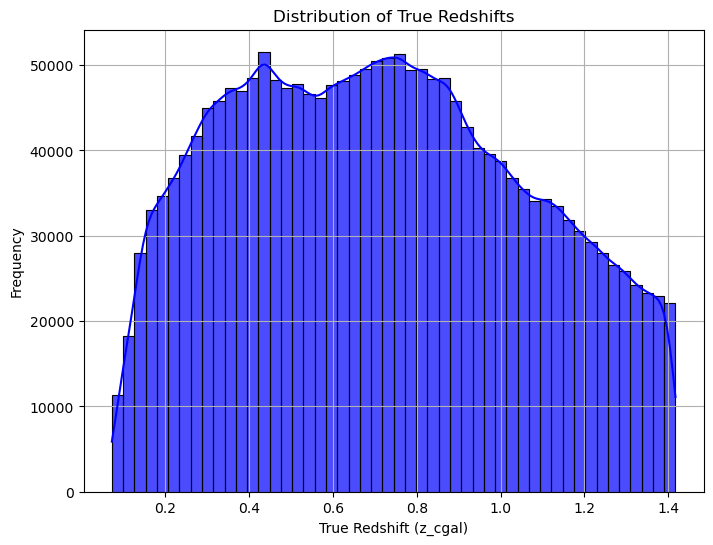

In [7]:
# Histogram of true redshifts
plt.figure(figsize=(8, 6))
sns.histplot(data_gal[target], bins=50, kde=True, color='blue', alpha=0.7)
plt.xlabel("True Redshift (z_cgal)")
plt.ylabel("Frequency")
plt.title("Distribution of True Redshifts")
plt.grid()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/true_redshifts.png")   
plt.show()

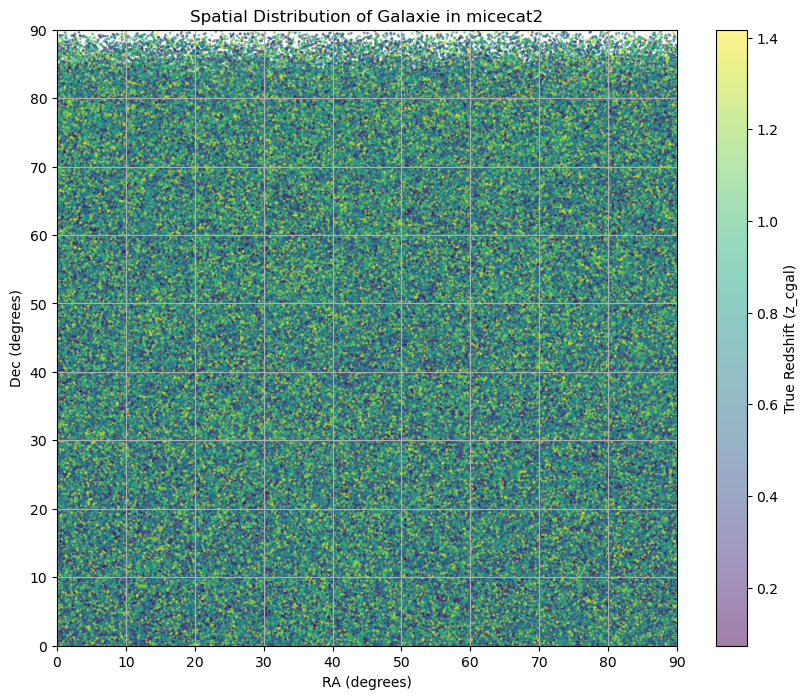

In [8]:
# Scatter plot of RA and Dec
plt.figure(figsize=(10, 8))
plt.scatter(data_gal['ra_gal'], data_gal['dec_gal'], s=1, alpha=0.5, c=data_gal[target], cmap='viridis')
plt.colorbar(label="True Redshift (z_cgal)")
plt.xlabel("RA (degrees)")
plt.ylabel("Dec (degrees)")
plt.xlim(0, 90)
plt.ylim(0, 90)
plt.title("Spatial Distribution of Galaxie in micecat2")
plt.grid()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/spatial_distribution.png")
plt.show()

### 2. Random Forest Regressor

In [9]:
# Standize the features
X = (X - X.mean()) / X.std()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=15, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 0.005012665807868794
R² Score: 0.9578324760036824


In [10]:
# Hyperparameter tuning: Varying the depth of the tree
max_depths = range(1, 21)  # Test tree depths from 1 to 20
mse_train = []  # Store MSE for training data
mse_test = []   # Store MSE for test data

for depth in max_depths:
    # Build and train the Random Forest model
    rf = RandomForestRegressor(n_estimators=100, max_depth=depth, random_state=42)
    rf.fit(X_train, y_train)
    
    # Predictions for training and test sets
    y_train_pred = rf.predict(X_train)
    y_test_pred = rf.predict(X_test)
    
    # Calculate MSE for training and test sets
    mse_train.append(mean_squared_error(y_train, y_train_pred))
    mse_test.append(mean_squared_error(y_test, y_test_pred))

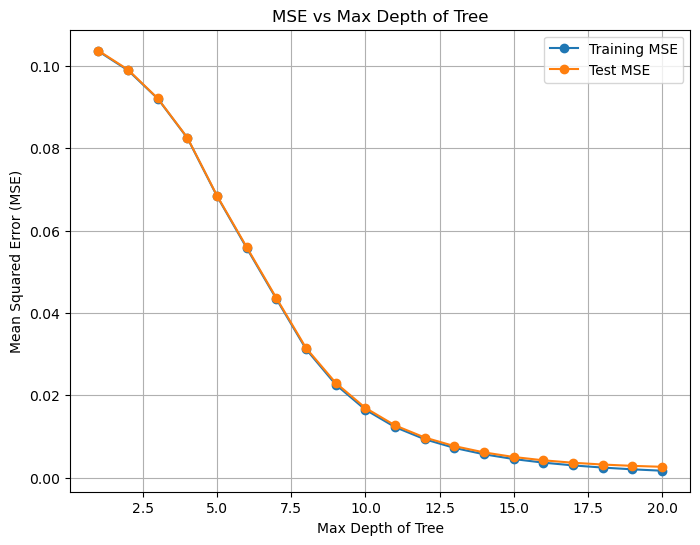

In [11]:
# Plot MSE vs Tree Depth
plt.figure(figsize=(8, 6))
plt.plot(max_depths, mse_train, label="Training MSE", marker='o')
plt.plot(max_depths, mse_test, label="Test MSE", marker='o')
plt.xlabel("Max Depth of Tree")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs Max Depth of Tree")
plt.legend()
plt.grid()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/MSE_vs_Max_Depth.png")
plt.show()

In [12]:
# Standize the features
X = (X - X.mean()) / X.std()
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build and train the Random Forest model
rf = RandomForestRegressor(n_estimators=100, max_depth=20, random_state=42)
rf.fit(X_train, y_train)

# Predictions
y_pred = rf.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

Mean Squared Error: 0.0026332872488254735
R² Score: 0.9778482732521809


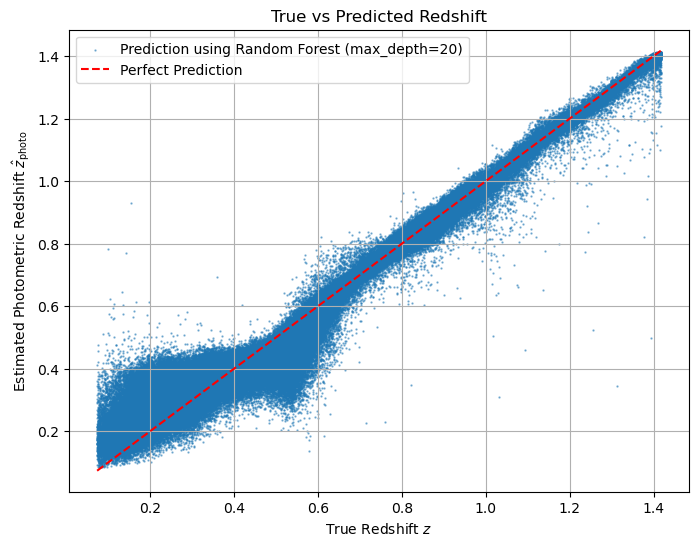

In [19]:
# Scatter plot of true vs predicted redshift
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, s=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Perfect Prediction")  # Diagonal line
plt.xlabel(r"True Redshift $z$")
plt.ylabel(r"Estimated Photometric Redshift $\hat{z}_\text{photo}$")
plt.title("True vs Predicted Redshift")
plt.legend(["Prediction using Random Forest (max_depth=20)","Perfect Prediction"])
plt.grid()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/true_vs_predicted_redshift.png")
plt.show()

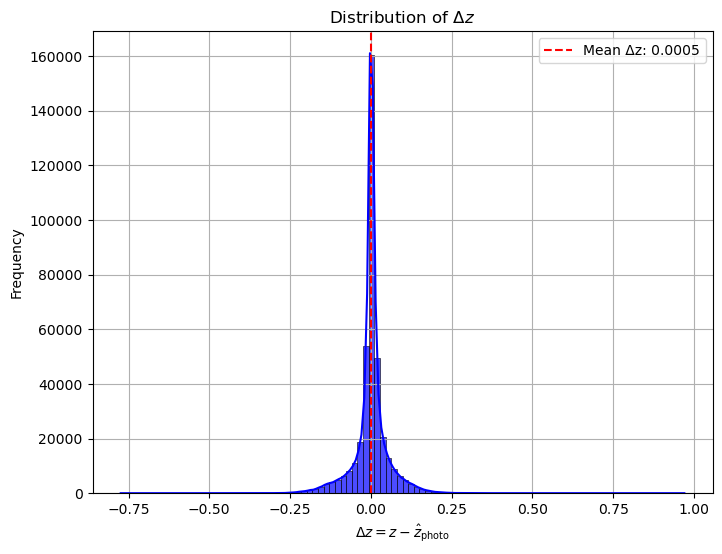

In [21]:
# Histogram of redshift differences
delta_z = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(delta_z, bins=100, kde=True, color="blue", alpha=0.7)
plt.axvline(delta_z.mean(), color='r', linestyle='--', label=f"Mean Δz: {delta_z.mean():.4f}")
plt.xlabel(r"$\Delta z = z - \hat{z}_\text{photo}$")
plt.ylabel("Frequency")
plt.title(r"Distribution of $\Delta z$")
plt.legend()
plt.grid()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/distribution_of_delta_z.png")
plt.show()

/var/folders/mp/1wz15_md6t38m_mg0pdw5dv40000gn/T/ipykernel_37059/3627147861.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances, y=features, palette="viridis")


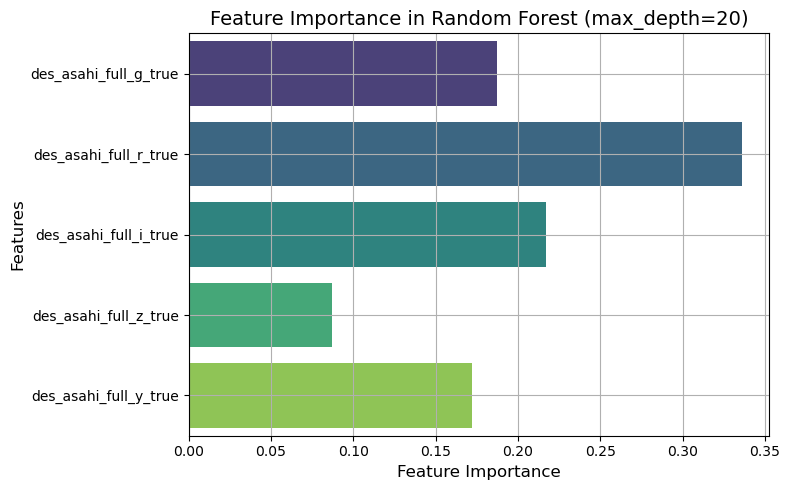

In [26]:
# Feature importance
importances = rf.feature_importances_
plt.figure(figsize=(8, 5))
sns.barplot(x=importances, y=features, palette="viridis")
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.title("Feature Importance in Random Forest (max_depth=20)", fontsize=14)
plt.grid()

# Adjust layout to ensure the entire plot is saved correctly
plt.tight_layout()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/feature_importance.png", dpi=300)
plt.show()

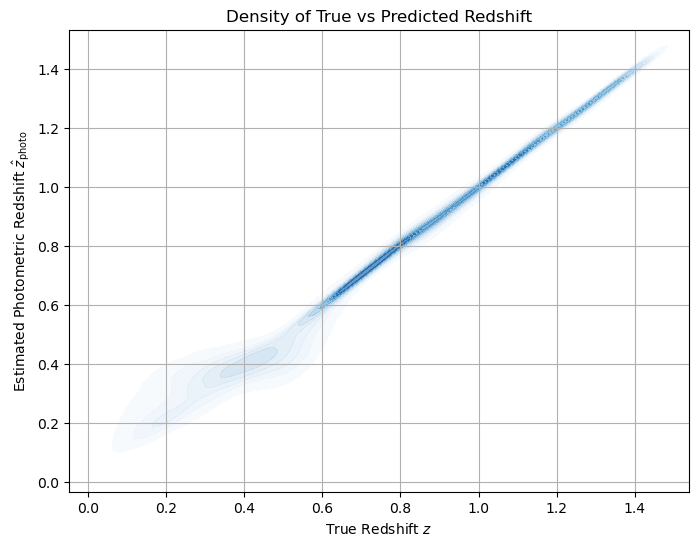

In [24]:
# Heatmap of predictions vs true values (for density visualization)
plt.figure(figsize=(8, 6))
sns.kdeplot(x=y_test, y=y_pred, fill=True, cmap="Blues", alpha=0.6)
plt.xlabel(r"True Redshift $z$")
plt.ylabel(r"Estimated Photometric Redshift $\hat{z}_\text{photo}$")
plt.title("Density of True vs Predicted Redshift")
plt.grid()
plt.savefig("/Users/r.kanaki/code/inlabru_nbody/output/Random_Forest/density_of_true_vs_predicted_redshift.png")
plt.show()